NOMBRES: Diego Alberto

APELLIDOS: Leiva Pérez

CARNE: 21752

FECHA: 25/09/2025

In [1]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt

**Ejercicio 1**
Cree un dataset con noticias (Pueden ser falsas) para poder clasificarlas por categoria (Recomiendo que sea binaria para su comodidad)

In [2]:
SEED=42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
def generar_dataset_noticias(news_sample=120, seed=42, as_df=True, csv_path=None):
    """
    Generate a synthetic dataset of news headlines in Spanish.
    Each headline is labeled as real (1) or fake (0).
    Params:
        news_sample (int): Number of samples per class (real and fake).
        seed (int): Random seed for reproducibility.
        as_df (bool): If True, return a pandas DataFrame; else return a list of dicts.
        csv_path (str or None): If provided, save the DataFrame to this CSV path
                                (only if as_df is True).
    Returns:
        pd.DataFrame or list of dicts: The generated dataset.
    """
    random.seed(seed)

    entidades = [
        "Guatemala","Quetzaltenango","Antigua Guatemala","Universidad del Valle",
        "Congreso","Ministerio de Salud","Municipalidad","CONRED",
        "Liga Nacional","SAT","Banco de Guatemala","CIV"
    ]
    temas = [
        "salud","educación","seguridad","economía","transporte",
        "tecnología","deporte","ambiente","cultura","energía"
    ]

    plantillas_reales = [
        "El {ent} anuncia nuevas medidas para {tema}",
        "{ent} presenta informe trimestral sobre {tema}",
        "{ent} inaugura proyecto de {tema} en {lugar}",
        "{ent} confirma operativo de control en {lugar}",
        "{ent} reporta incremento del {porc}% en {tema}",
        "{ent} establece convenio para fortalecer {tema}",
        "{ent} publica calendario oficial de {tema}",
        "{ent} implementa campaña nacional de {tema}",
        "{ent} actualiza protocolo de {tema}",
        "{ent} realiza jornada de {tema} en {lugar}",
    ]
    plantillas_falsas = [
        "Confirman llegada de extraterrestres a {lugar}",
        "Descubren fórmula para vivir {anios} años",
        "Anuncian que los dragones regresarán en {lugar}",
        "Habilitan viajes en el tiempo desde {lugar}",
        "Revelan que la Tierra es hueca bajo {lugar}",
        "Presentan dispositivo que lee la mente en {lugar}",
        "Aseguran que el café cura todas las enfermedades",
        "Afirman que un meteorito de oro cayó en {lugar}",
        "Garantizan ganar la lotería con un método secreto",
        "Prometen internet gratuito mundial desde mañana",
    ]

    def sreal():
        """
        Generate a synthetic real news headline.
        """
        ent = random.choice(entidades)
        t   = random.choice(temas)
        tpl = random.choice(plantillas_reales)
        txt = tpl.format(
            ent=ent, tema=t, lugar=random.choice(entidades),
            porc=random.randint(3,35)
        )
        return txt + "."

    def sfake():
        """
        Generate a synthetic fake news headline.
        """
        tpl = random.choice(plantillas_falsas)
        txt = tpl.format(
            lugar=random.choice(entidades),
            anios=random.randint(150,500)
        )
        return txt + "."

    data = []
    for _ in range(news_sample):
        data.append({"text": sreal(), "label": 1})
    for _ in range(news_sample):
        data.append({"text": sfake(), "label": 0})

    random.shuffle(data)

    # Generate dataframe or list of dicts
    if as_df:
        df = pd.DataFrame(data)
        if csv_path:
            df.to_csv(csv_path, index=False)
            print(f"CSV guardado en: {csv_path}")
        return df
    else:
        # Lista de dicts
        for r in data[:5]:
            print(r)
        return data

In [4]:
df = generar_dataset_noticias(news_sample=120, as_df=True, csv_path="dataset_es.csv")
pd.set_option('display.max_colwidth', None)
df.head()

CSV guardado en: dataset_es.csv


,text,label
0,Ministerio de Salud actualiza protocolo de seguridad.,1
1,Liga Nacional actualiza protocolo de deporte.,1
2,CIV realiza jornada de energía en CONRED.,1
3,Anuncian que los dragones regresarán en Universidad del Valle.,0
4,Confirman llegada de extraterrestres a Universidad del Valle.,0


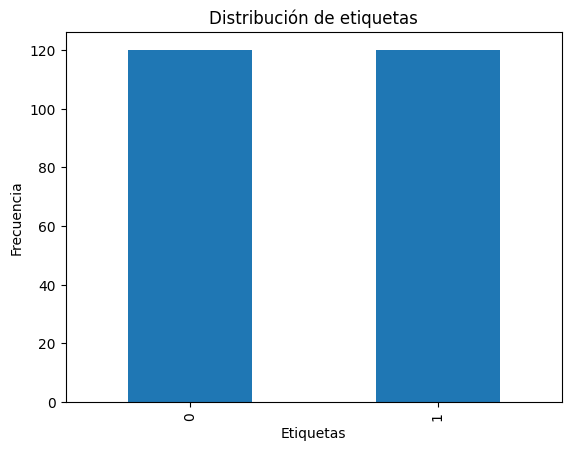

In [5]:
plt.figure()
df['label'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribución de etiquetas")
plt.xlabel("Etiquetas")
plt.ylabel("Frecuencia")
plt.show()

**Ejercicio 2**
 En base al dataset creado anteriormente Realizar una CNN para poder clasificarla de manera automatica, debe de realizarla con 3 filtros y dejar cada una de ellas como una implementacion nuevo por lo que recomiendo trabajarlo por funciones

In [6]:
# Assert dataset labels
assert set(["text","label"]).issubset(df.columns)
df["label"] = df["label"].astype(int)

# Stratified split
X_temp, X_test, y_temp, y_test = train_test_split(
    df["text"].values, 
    df["label"].values, 
    test_size=0.1,
    random_state=SEED, 
    stratify=df["label"].values
    )

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.1111,
    random_state=SEED,
    stratify=y_temp
    )

# Tensors with tensorflow datasets
train_raw = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_raw   = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_raw  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Hyperparameters
BATCH_SIZE = 64
MAX_TOKENS = 20000
SEQ_LEN = 32
EMB_DIM = 128
DROPOUT = 0.5
EPOCHS = 8
LR = 1e-3

# Vectorization and preprocessing
vectorizer = layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode="int",
    output_sequence_length=SEQ_LEN,
    standardize="lower_and_strip_punctuation",
)
vectorizer.adapt(train_raw.map(lambda x,y:x))

In [7]:
def preprocess(x,y):
    """
    Preprocess function to vectorize text and cast labels.
    Params:
        x (tf.Tensor): Input text tensor.
        y (tf.Tensor): Input label tensor.
    Returns:
        tuple: (vectorized text tensor, casted label tensor)
    """
    return vectorizer(x), tf.cast(y, tf.int32)

In [8]:
# Data pipeline with shuffling, batching, and prefetching
train = (train_raw
         .map(preprocess)
         .cache()
         .shuffle(5000, seed=SEED)
         .batch(BATCH_SIZE, drop_remainder=True)
         .prefetch(tf.data.AUTOTUNE))

val   = (val_raw
         .map(preprocess)
         .cache()
         .batch(BATCH_SIZE)
         .prefetch(tf.data.AUTOTUNE))

test  = (test_raw
         .map(preprocess)
         .cache()
         .batch(BATCH_SIZE)
         .prefetch(tf.data.AUTOTUNE))

# Y true for evaluation
y_true = y_test.astype(int)

In [9]:
def build_cnn(kernel_size:int)->tf.keras.Model:
    """
    Build and compile a CNN model with the specified kernel size.
    Params:
        kernel_size (int): Size of the convolutional kernel.
    Returns:
        tf.keras.Model: The compiled CNN model.
    """
    inputs = layers.Input(shape=(SEQ_LEN,), dtype=tf.int32)
    x = layers.Embedding(input_dim=MAX_TOKENS, output_dim=EMB_DIM, name="emb")(inputs)
    x = layers.Conv1D(filters=128, kernel_size=kernel_size, activation="relu", padding="valid", name=f"conv_k{kernel_size}")(x)
    x = layers.GlobalMaxPooling1D(name=f"gmp_k{kernel_size}")(x)
    x = layers.Dropout(DROPOUT)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(DROPOUT)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = Model(inputs, outputs, name=f"cnn_k{kernel_size}")
    model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [10]:
# Define and train models with different kernel sizes
kernel_sizes = [3,4,5]
histories = {}

# Loop over kernel sizes
for k in kernel_sizes:
    # Train model
    model = build_cnn(k)
    cb = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)]
    h = model.fit(train, validation_data=val, epochs=EPOCHS, callbacks=cb, verbose=0)
    histories[k] = h

    # Evaluate model
    print(f"--- Modelo con filtro de tamaño {k} ---")
    y_prob = model.predict(test, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    print(classification_report(y_true, y_pred, zero_division=0))

--- Modelo con filtro de tamaño 3 ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

--- Modelo con filtro de tamaño 4 ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

--- Modelo con filtro de tamaño 5 ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg  

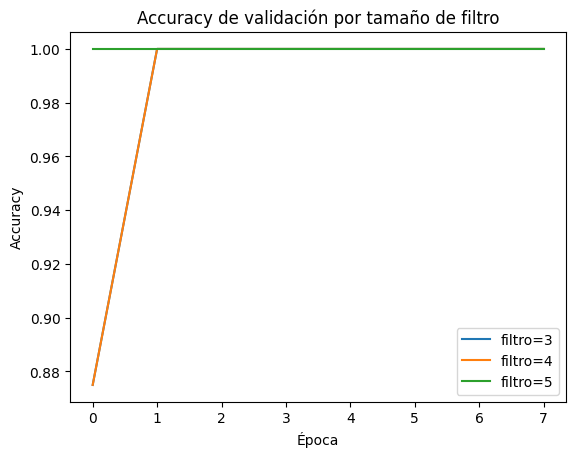

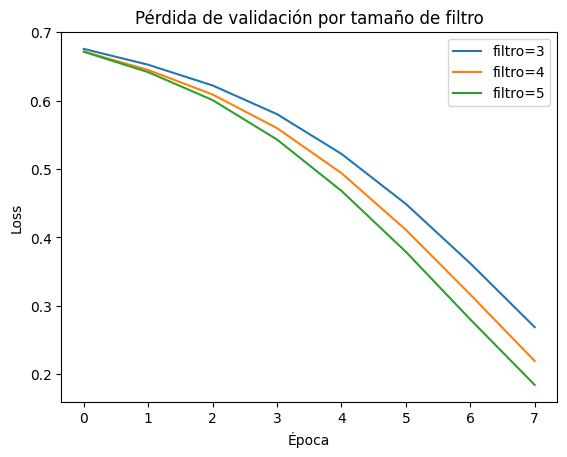

In [11]:
# Curvas
plt.figure()
for k,h in histories.items():
    plt.plot(h.history["val_accuracy"], label=f"filtro={k}")
plt.title("Accuracy de validación por tamaño de filtro")
plt.xlabel("Época"); plt.ylabel("Accuracy"); plt.legend()
plt.show()

plt.figure()
for k,h in histories.items():
    plt.plot(h.history["val_loss"], label=f"filtro={k}")
plt.title("Pérdida de validación por tamaño de filtro")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.legend()
plt.show()

**Ejercicio 3**
Debe de discutir sus resultados y realizar una comparacion de porque varia dependiendo del filtro que se use

Los tres modelos alcanzaron **1.00** de accuracy y F1 en test para `k=3,4,5`. Esto indica un **efecto techo** causado por la alta separabilidad del dataset sintético y la brevedad de los titulares: existen *“palabras gatillo”* distintivas por clase y cualquier ventana 3–5 captura los mismos n-gramas útiles. La única diferencia observable aparece en la **pérdida**: es ligeramente menor con `k=5`, lo que refleja **mayor confianza** en las predicciones ya correctas, no más aciertos. En otras palabras, cambia la **calibración** de las probabilidades, no la precisión.

En escenarios más naturales sí esperaría variación por tamaño de filtro: `k=3` suele favorecer expresiones cortas y señales locales, `k=5` puede capturar dependencias algo más largas en oraciones compuestas, y `k=4` funciona como equilibrio.